In [39]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from scipy.optimize import root
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from equilibria_funs import *
from sim_graph_funs import *
figureops = dict(bbox_inches = 'tight', dpi = 600)
colors_x = ['k', 'b', 'r', 'm']

In [40]:
def get_initial_points(num_initial, A, η1, η2,  x_max, H1, H2,**params):
    ''' 
    get initial points to feed to the root finder 
    '''
    α2_1 = params['α2_of_1']
    α1_xm = fun_alpha1(x_max, **params)
    # gx_upper = np.min([
    #     η1 /A * np.sum([fun_alpha1(x,**params) for x in range(1,x_max+1)]),
    #     η2 /A * np.sum([fun_alpha2(x, **params) for x in range(1,x_max+1)]),
    # ])
    gx_upper = 3# try this out
    # Generate random values for N1, N2, and g(x) for each initial point
    np.random.seed(42)
    
    # N1 and N2 are between 0 and 1
    N1_values = np.random.uniform(0, 1, num_initial)  # Shape: (num_initial,)
    N2_values = np.random.uniform(0, 1, num_initial)  # Shape: (num_initial,)
    
    # g(x) is between 0 and gx_upper for each x = 1, 2, ..., x_max
    g_values = np.random.uniform(0, gx_upper, (num_initial, x_max))  # Shape: (num_initial, x_max)
    # Combine N1, N2, and g(x) into a single array
    initial_points = np.hstack((N1_values[:, np.newaxis],  # Add N1 as the first column
                                N2_values[:, np.newaxis],  # Add N2 as the second column
                                g_values))  # Add g(x) as the remaining columns
    
    return initial_points
def get_equilibria_from_init_pts(initial_points, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    results = []
    for i, point in enumerate(initial_points):
        out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq])

            # append new_eq if it's unique from the last one
            if np.any(np.abs(new_eq - curr_eq) > 1e-8):
                results.append([N1_eq, N2_eq, *g_eq, mean_x_eq])
                curr_eq = new_eq
    return results
def get_perturbations(equilibrium, num, strength):
    '''
    @inputs:
    equilibrium - N1, N2, g(1), ... g(x_max)
    num - number of perturbations to return
    TO-DO
    '''

    #  initiate empty array
    perturbations = np.zeros((num, equilibrium.shape[0]))

    # fill array
    for i in range(0,num):
        #perturb
        curr_perturbed = equilibrium + strength * np.random.standard_normal(len(equilibrium))
        curr_perturbed[0:2] = np.clip(curr_perturbed[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
        curr_perturbed[2:] = np.clip(curr_perturbed[2:], a_min = 1e-8, a_max = None)
        perturbations[i,:] = curr_perturbed
    return perturbations

def classify_equilibrium(equilibrium, params):
    '''
    equilibrium = [N1, N2, *gvec]
    '''
    [N1,N2,*gvec] = equilibrium
    J = fun_Jac(N1,N2,gvec,**params)
    stability = classify_stability(J)
    return stability
    # returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)"
    # and "Indeterminate stability (needs further analysis)"

def classify_and_store_equilibrium(equilibrium, stable_points, unstable_points, param, params):
    result = [param,*equilibrium]
    stability = classify_equilibrium(equilibrium[:-1],params)
    
    if stability == "Stable (attractive)":
        stable_points.append(result)
        
    elif stability == "Unstable":
        unstable_points.append(result)
    return stable_points, unstable_points
def store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points, 
                                 params, num_perturbations, perturb_strength):
    '''
    iterate through equilibria found for one parameter entry, classify them, 
    and find perturbations for next iteration

    the equilibria given are from solving nullclines iwth N1!=0, N2 != 0
    '''



    # loop over each (non-extinction) equilibrium
    for equilibrium in equilibria:
        # if unique, add to equilibria vector with the param in the first entry

        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points, param, params)
        
        # get a few perturbations from the equilibrium to generate new points to start from --> aadd this to perturbed pts vector
        perturbed_pts = get_perturbations(np.array(equilibrium[:-1]), 
                                              num_perturbations, perturb_strength)


    return stable_points, unstable_points, perturbed_pts

def update_params(param_key, param, params_base):
    params = params_base.copy()
        
    if param_key == "scale": # this means β1/β2 = H1/H2 and β2, H2 are set
        params['β1'] = params['β2']*param
        params['H1'] = params['H2']*param
    else:
        params[param_key] = param
    return params
    
def store_pred_extinction_equilibria(stable_points, unstable_points, param, params):
    # add on predator extinction equilibria
    g_of_x_extinct = np.zeros(params['x_max'])
    pred_extinct_equilibria = [[1,1,*g_of_x_extinct,1],[1,0,*g_of_x_extinct,1],
                               [0,1,*g_of_x_extinct,1]]

    # now add on prey extinction equilibria
            # TO-DO
    # First big prey extinct

    for equilibrium in pred_extinct_equilibria:
        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points, param, params)
    return stable_points, unstable_points

In [41]:
def get_equilibria_from_init_pts_i_extinct(results, initial_points, i, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria
    prey i (1 or 2) extinct
    I need to ignore the first column from the initial points
    append to results if found an equilibrium

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    
    for point in initial_points:
        out = get_equilibrium_prey_i_extinct(params, i, Nj_0 = point[1], 
                                             g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8, which_prey_extinct = i)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq])

            # append new_eq if it's unique from the last one
            if np.any(np.abs(new_eq - curr_eq) > 1e-8):
                results.append([N1_eq, N2_eq, *g_eq, mean_x_eq])
                curr_eq = new_eq
    return results

In [42]:

def get_bif_diagram_input(param_key, param_vec, num_init = 30, num_perturbations = 2,
                          perturb_strength = 0.01, 
                          **params_base):
    '''
    for a parameter that's varied, finds the equilibria and their stability
    '''
    # initiate empty vectors to be filled
    
    # initiate empty perturbed_pts vector, containing points perturbed from the last set of equilibria
    perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])
    
    #initiate empty vectors for stable and unstable pints
    stable_points = []
    unstable_points = []

    for param in param_vec:
        # update param dictionary. if using scaling laws, need to update
    
        # params = params_base.copy()
        # params[param_key] = param
        params = update_params(param_key, param, params_base)
    
        # get some random initial points
        init_pts = get_initial_points(num_initial=num_init,**params.copy())
        init_pts = np.vstack((init_pts,perturbed_pts))
        
        # find equilibria starting from initialpoints and perturbed_pts. already checked for uniqueness
        # each row has N1, N2, g(1), .. g(x_max), \bar{x}
        coexist_equilibria = get_equilibria_from_init_pts(init_pts, **params.copy())

        # add big prey extinct equilibria 
        coexist_and_big_prey_extinct_equilibria = get_equilibria_from_init_pts_i_extinct(
            coexist_equilibria, init_pts,1,**params.copy()
        )
        # add small prey extinct equilibria using initpts 
        pred_not_extinct_equilibria = get_equilibria_from_init_pts_i_extinct(
            coexist_and_big_prey_extinct_equilibria, init_pts,2,**params.copy()
        )

        # below with this new big list
        
        if np.size(pred_not_extinct_equilibria) > 0:
            out = store_equilibria_and_perturb(
                param, pred_not_extinct_equilibria, stable_points, unstable_points, 
                                           params, num_perturbations, perturb_strength
            )
            stable_points, unstable_points, perturbed_pts  = out
            
        stable_points, unstable_points = store_pred_extinction_equilibria(
                                        stable_points, unstable_points, 
                                        param, params
        )
    
    # Convert to numpy arrays for easier manipulation
    stable_points = np.array(stable_points)
    unstable_points = np.array(unstable_points)
    return stable_points, unstable_points
    
def plot_bif_diagram(stable_points, unstable_points, xlab):
    '''
    using the output from get_bif_diagram_input, plots a bifurcation diagram
    '''
    figx, axx = plt.subplots(1,1)
    figN1, axN1 = plt.subplots(1,1)
    figN2, axN2 = plt.subplots(1,1)

    stable_markers = dict(label = "Stable", marker = "o", s = 5, color = "black")
    unstable_markers = dict(label = "Unstable", marker = "*", s = 30, color = "red")
    
    
    if stable_points.size > 0:
        axN1.scatter(stable_points[:, 0], stable_points[:, 1], **stable_markers)
        axN2.scatter(stable_points[:, 0], stable_points[:, 2], **stable_markers)
        axx.scatter(stable_points[:, 0], stable_points[:, -1], **stable_markers)
    
    if unstable_points.size > 0:
        axN1.scatter(unstable_points[:, 0], unstable_points[:, 1], **unstable_markers)
        axN2.scatter(unstable_points[:, 0], unstable_points[:, 2],  **unstable_markers)
        axx.scatter(unstable_points[:, 0], unstable_points[:, -1], **unstable_markers)
    
     
    for ax, ylab in zip([axx, axN1, axN2],[mean_x_lab, N1lab, N2lab]):
        format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True,
             ncol_legend = 1)
    return figx, figN1, figN2

# Type I

In [43]:
H = 0
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [45]:
stable_points, unstable_points = get_bif_diagram_input('β1', np.linspace(1.1,10,30),  
                          **params_base)


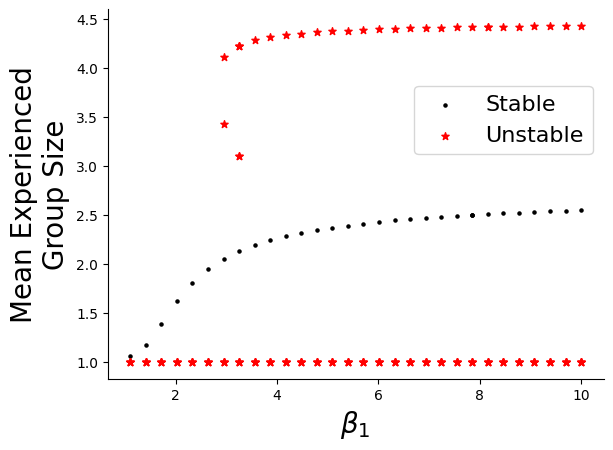

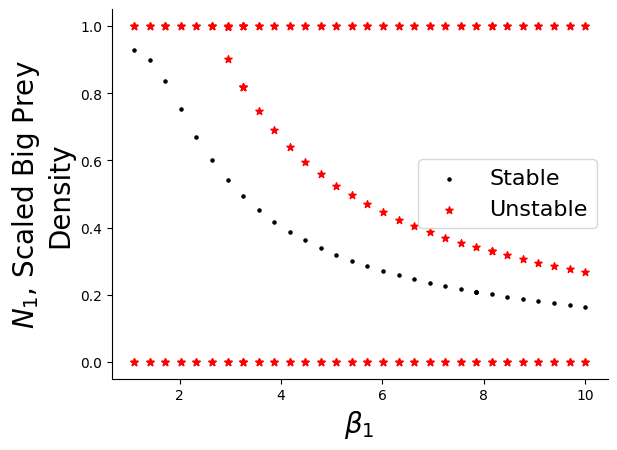

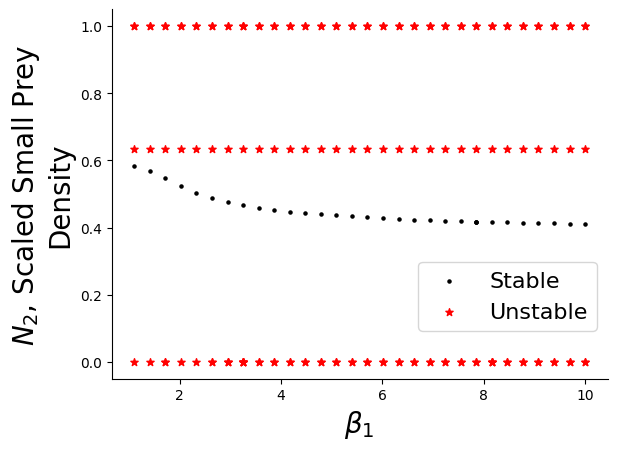

In [46]:
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\beta_1$')

# fix mean_x legend
axx = figx.axes[0]
legendx = axx.get_legend() 
current_font_properties = legendx.prop  # Retrieve current font properties

# loc='center right' specifies the anchor point of the legend box
# bbox_to_anchor=(1, 0.6) moves the legend slightly to the right (x=1) and slightly above the center  (y=0.6).
axx.legend(loc='center right', bbox_to_anchor=(1, 0.7), prop=current_font_properties)

# fix N2 legend
ax2 = figN2.axes[0]
legend2 = ax2.get_legend()
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.1), prop = current_font_properties)

In [53]:
stable_points, unstable_points = get_bif_diagram_input('η1', np.linspace(0.01,params_base['η2'],30),  
                          **params_base)


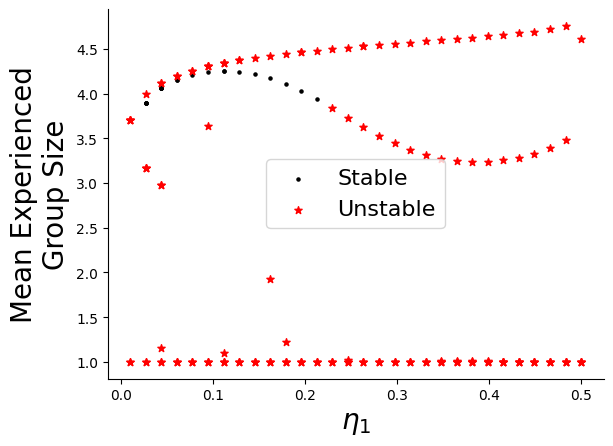

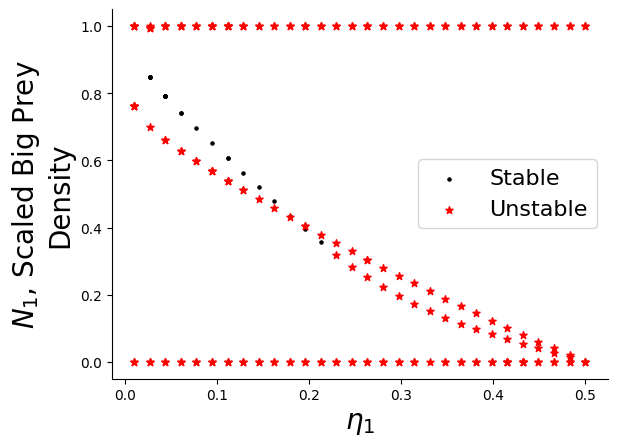

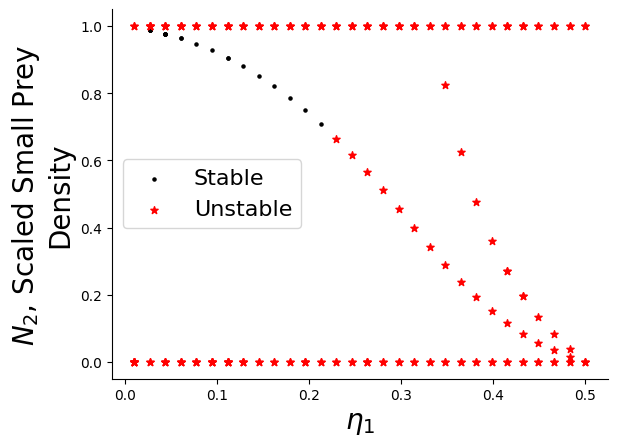

In [54]:
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\eta_1$')

# Type II

In [49]:
H = 2
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

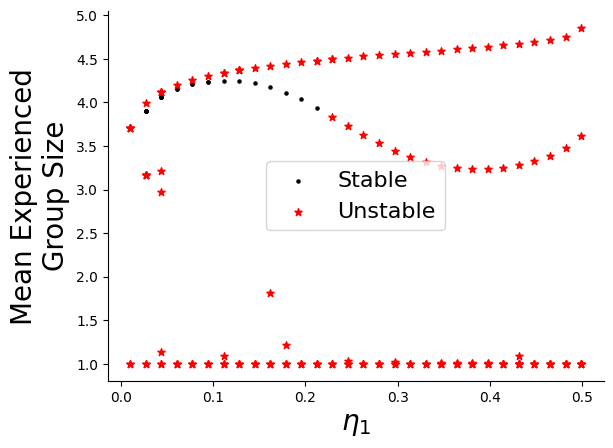

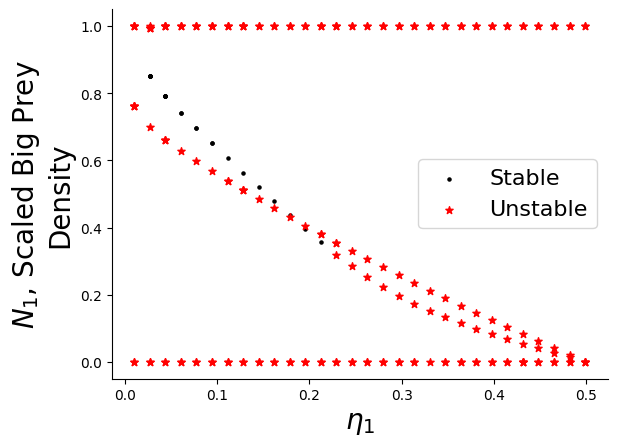

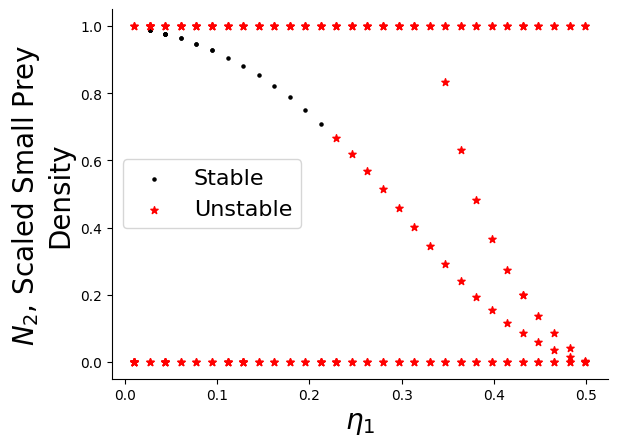

In [50]:
stable_points, unstable_points = get_bif_diagram_input('η1', np.linspace(0.01,params_base['η2']-0.001,30),  
                          **params_base)
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\eta_1$')

# Type II, $H_1$, $\beta_1$ scaled

In [58]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

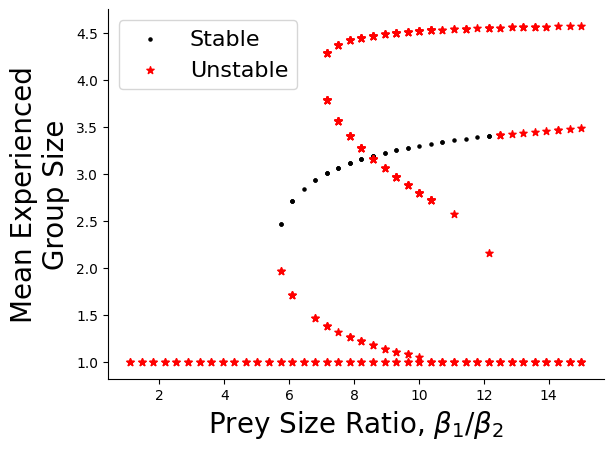

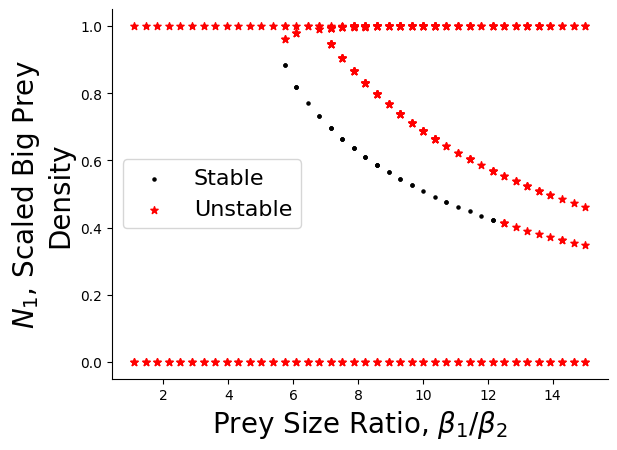

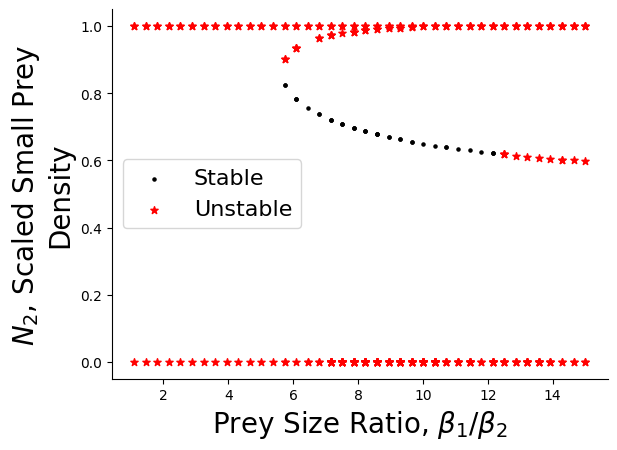

In [63]:
stable_points, unstable_points = get_bif_diagram_input('scale', np.linspace(1.1,15,40),  
                          **params_base, num_init = 25)
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = "Prey Size Ratio, " + r'$\beta_1/\beta_2$')